In [1]:
from keras.datasets import mnist
from keras.utils import to_categorical

def prepare_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape((-1, 28, 28, 1)) / 255.
    x_test = x_test.reshape((-1, 28, 28, 1)) / 255.
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = prepare_mnist()
print(x_train.shape)
print(x_train.min(), x_train.max())

Using TensorFlow backend.


(60000, 28, 28, 1)
0.0 1.0


# Simple Conv

In [3]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=6, kernel_size=5, padding='same', strides=1, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=3))
model.add(Flatten())
model.add(Dense(units=10, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(x_train, y_train, epochs=10, validation_split=.3)


Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 13s 320us/step - loss: 0.4211 - acc: 0.8814 - val_loss: 0.2110 - val_acc: 0.9374
Epoch 2/10
42000/42000 [==============================] - 13s 307us/step - loss: 0.1862 - acc: 0.9439 - val_loss: 0.1608 - val_acc: 0.9502
Epoch 3/10
42000/42000 [==============================] - 13s 306us/step - loss: 0.1396 - acc: 0.9579 - val_loss: 0.1238 - val_acc: 0.9639
Epoch 4/10
42000/42000 [==============================] - 13s 301us/step - loss: 0.1133 - acc: 0.9674 - val_loss: 0.1077 - val_acc: 0.9690
Epoch 5/10
42000/42000 [==============================] - 12s 295us/step - loss: 0.0972 - acc: 0.9710 - val_loss: 0.0965 - val_acc: 0.9708
Epoch 6/10
42000/42000 [==============================] - 12s 295us/step - loss: 0.0847 - acc: 0.9752 - val_loss: 0.0884 - val_acc: 0.9734
Epoch 7/10
42000/42000 [==============================] - 12s 298us/step - loss: 0.0759 - acc: 0.9777 - val_loss: 0.

# LeNet

In [4]:
model = Sequential()
model.add(Conv2D(filters=6, kernel_size=5, padding='valid', strides=1, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=16, kernel_size=5, padding='valid', strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=120, activation="relu"))
model.add(Dense(units=84, activation="relu"))
model.add(Dense(units=10, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

model.fit(x_train, y_train, epochs=10, validation_split=.3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_4 (Dense)              (None, 84)                10164     
__________

# Fine tuning

In [5]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 8s 0us/step


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [21]:
img_path = "../data/kangaroo_DirkFreder_iStock_623-18af7bd.jpg"
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)


In [22]:
import matplotlib.pyplot as plt

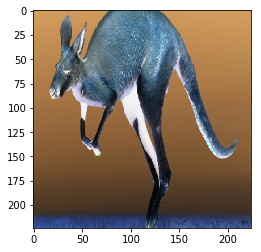

In [23]:
plt.imshow(x,interpolation='nearest')

In [24]:
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [25]:
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 2us/step
Predicted: [('n01877812', 'wallaby', 0.7412765), ('n02437616', 'llama', 0.10669878), ('n02423022', 'gazelle', 0.054088503)]


## Fine tuning on CIFAR

In [26]:
from keras.datasets import cifar10
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

170500096/170498071 [==============================] - 57s 0us/step


In [29]:
from keras.layers import Dropout
from keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=x_train.shape[1:])
for layer in base_model.layers:
    layer.trainable = False

full_model = Sequential()
full_model.add(base_model)
full_model.add(Flatten())
full_model.add(Dropout(rate=.5))
full_model.add(Dense(128, activation="relu"))
full_model.add(Dropout(rate=.5))
full_model.add(Dense(128, activation="relu"))
full_model.add(Dropout(rate=.5))
full_model.add(Dense(10, activation="softmax"))

opt=Adam(lr=1e-4)
full_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

full_model.summary()



/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
__________

In [30]:
full_model.fit(x_train, y_train, epochs=10, validation_split=.3, batch_size=512)

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 129s 4ms/step - loss: 4.0884 - acc: 0.1037 - val_loss: 2.5263 - val_acc: 0.0978
Epoch 2/10
35000/35000 [==============================] - 127s 4ms/step - loss: 3.0422 - acc: 0.1161 - val_loss: 2.4470 - val_acc: 0.0979
Epoch 3/10
35000/35000 [==============================] - 135s 4ms/step - loss: 2.7071 - acc: 0.1205 - val_loss: 2.3982 - val_acc: 0.0979
Epoch 4/10
35000/35000 [==============================] - 127s 4ms/step - loss: 2.5343 - acc: 0.1268 - val_loss: 2.3741 - val_acc: 0.0979
Epoch 5/10
35000/35000 [==============================] - 130s 4ms/step - loss: 2.4538 - acc: 0.1282 - val_loss: 2.3610 - val_acc: 0.0979
Epoch 6/10
35000/35000 [==============================] - 123s 4ms/step - loss: 2.3836 - acc: 0.1358 - val_loss: 2.3541 - val_acc: 0.0978
Epoch 7/10
35000/35000 [==============================] - 127s 4ms/step - loss: 2.3549 - acc: 0.1345 - val_loss: 2.3474 - 

In [33]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = full_model.predict(x_test, batch_size=32)

[INFO] evaluating network...


In [34]:
from sklearn.metrics import classification_report

In [35]:
print(classification_report(y_test.argmax(axis=1),predictions.argmax(axis=1)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1000
          1       0.00      0.00      0.00      1000
          2       0.11      0.94      0.19      1000
          3       0.00      0.00      0.00      1000
          4       0.06      0.09      0.07      1000
          5       0.00      0.00      0.00      1000
          6       0.00      0.00      0.00      1000
          7       0.00      0.00      0.00      1000
          8       0.00      0.00      0.00      1000
          9       0.00      0.00      0.00      1000

avg / total       0.02      0.10      0.03     10000



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
